In [28]:
import numpy as np

f0 = 60      # min frequency
B = 3239     # sweep bandwidth
S = 54       # sweep slope
fs = 4000    # sampling freq
Nc = 256     # num chirps in 1 frame
Ns = 128     # num samples of 1 chirp 
c0 = 3e+8
idle_time = 5e-6

fc = f0+B/2000   #center frequency
lamda = c0/(fc*1e+9)
Tc= idle_time + (B/S)*(1e-6)

# range resolution
R_res = c0 / (2e+6*B)       
R_max = fs*c0 / (2e+9*S)


# Velocity resolution
velocity_res = lamda/(2*Nc*Tc)
v_max = lamda/(4*Tc)

print(R_res)
print(R_max)
print(velocity_res)
print(v_max)

0.04631058968817536
11.11111111111111
0.14633341751423926
18.730677441822625


In [29]:
from scipy import signal
import torch
def data_preprocessing(data):
    # NTS = 128
    # nc = 1
    Data_time = data
    tmp = np.fft.fft(Data_time, axis=0)
    b, a = signal.butter(4, 0.0075, 'high')   
    # Perform Range
    Data_range_MTI = signal.lfilter(b,a,tmp, axis=1)
    # Perform Doppler FFT
    Doppler_fft = np.fft.fft(Data_range_MTI, axis=1)
    # Doppler_fft = signal.lfilter(b,a,Doppler_fft, axis=0)


    bin_indl = 10
    bin_indu = 80
    # _, __, Data_MTI_temp = signal.stft(Data_range_MTI[bin_indl:bin_indu,:],nperseg=512,noverlap=256,nfft=512, boundary=None, padded=False, return_onesided=False)
    _, __, Data_MTI_temp = signal.stft(Data_range_MTI,nperseg=512,noverlap=256,nfft=512, boundary=None, padded=False, return_onesided=False)
    Data_MTI_temp = np.sum(Data_MTI_temp, axis=0)
    Data_MTI_temp = np.flipud(np.fft.fftshift((Data_MTI_temp), axes=(0,)))
    return Data_range_MTI, Data_MTI_temp, Doppler_fft

In [30]:
import numpy as np

file_name = "Dat_sit_0_4chair.bin"

# global variables
num_adc_samples = 128  # number of ADC samples per chirp
num_adc_bits = 16  # number of ADC bits per sample
num_rx = 4  # number of receivers
num_lanes = 2  # do not change. number of lanes is always 2
is_real = 0  # set to 1 if real only data, 0 if complex data

# read file
with open(file_name, 'rb') as fid:
    adc_data = np.fromfile(fid, dtype=np.int16)

# if 12 or 14 bits ADC per sample compensate for sign extension
if num_adc_bits!= 16:
    l_max = 2**(num_adc_bits-1)-1
    adc_data[adc_data > l_max] -= 2**num_adc_bits

file_size = adc_data.size

# for complex data
# file_size = 2 * num_adc_samples*num_chirps
num_chirps = file_size // (2 * num_adc_samples * num_rx)
file_size = num_chirps * (2 * num_adc_samples * num_rx)
lvds = np.zeros((file_size // 2,), dtype=complex)
counter = 0
adjusted_size = (file_size // 4) * 4
# print(file_size)
# for i in range(0, file_size-1, 4):
#     lvds[counter] = adc_data[i] + 1j * adc_data[i+2]
#     lvds[counter+1] = adc_data[i+1] + 1j * adc_data[i+3]
#     counter += 2
lvds[0::2] = adc_data[0:adjusted_size:4] + 1j * adc_data[2:adjusted_size:4]
lvds[1::2] = adc_data[1:adjusted_size:4] + 1j * adc_data[3:adjusted_size:4]

lvds = lvds.reshape((num_chirps, num_adc_samples * num_rx))
n_c = lvds.shape[0]     #num chirps
lvds.shape


new_adc_data = np.zeros((num_rx, num_chirps * num_adc_samples), dtype=np.complex128)
for row in range(num_rx):
    for i in range(num_chirps):
        new_adc_data[row, i*num_adc_samples:(i+1)*num_adc_samples] = lvds[i, row*num_adc_samples:(row+1)*num_adc_samples]
# new_adc_data

def read_rx(rx1):
    rx1 = np.reshape(rx1, (n_c, 128))
    rx1 = rx1.T
    return rx1

rx1 = read_rx(new_adc_data[0, :])
rx2 = read_rx(new_adc_data[1, :])
rx3 = read_rx(new_adc_data[2, :])
rx4 = read_rx(new_adc_data[3, :])
rx_arr = np.stack((rx1, rx2, rx3, rx4))
# doppler_arr.shape

rD1, mD1, Dop = data_preprocessing(rx1)
rD2, mD2, _ = data_preprocessing(rx2)
rD3, mD3, _ = data_preprocessing(rx3)
rD4, mD4, _ = data_preprocessing(rx4)

n_chirps = rx_arr.shape[-1]
mD_max = mD1.shape[-1]
print(np.shape(mD1))
print(np.size(rD1, 1))
print(mD_max)

(512, 633)
162432
633


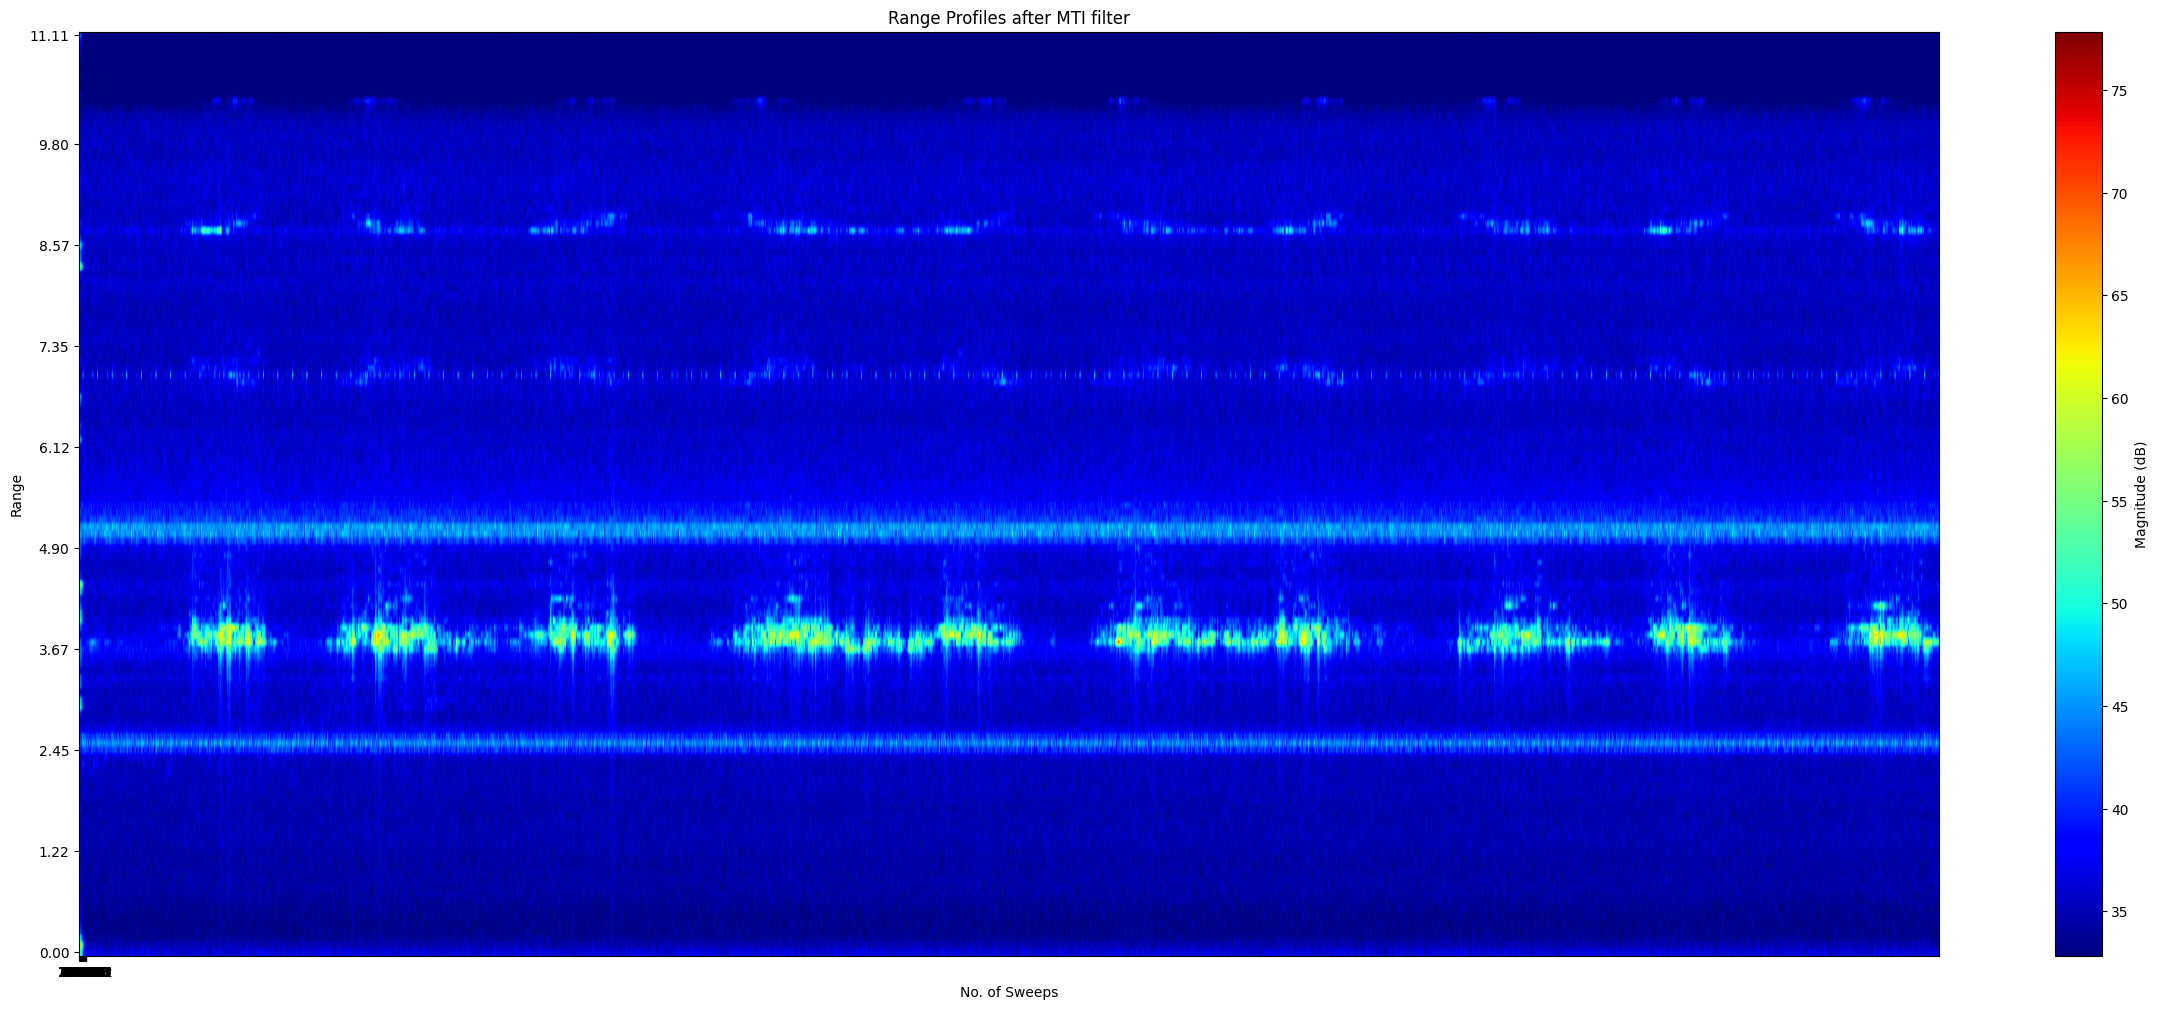

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(30, 12))
# Plot the spectrogram
im = ax.imshow(20 * np.log10(np.abs(rD1)), cmap='jet', aspect='auto')

# Set the axis labels and title
ax.set_xlabel('No. of Sweeps')
ax.set_ylabel('Range')
ax.set_title('Range Profiles after MTI filter')

#Set the y-axis ticks and labels
yticks = np.linspace(0, 127, 10, dtype=int)
ax.set_yticks(yticks)
ax.set_yticklabels(['{:.2f}'.format(i*R_max/127) for i in yticks])

xticks = np.linspace(0, mD_max, 30, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels(['{:.0f}'.format(i*n_chirps/mD_max) for i in xticks])

# Set the colorbar limits
clim = im.get_clim()
im.set_clim(clim[1] - 45, clim[1])

# Flip the y-axis to match MATLAB's behavior
ax.invert_yaxis()

# # Adjust the y-axis limits
# ax.set_ylim([0, 127])

# Add the colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Magnitude (dB)')

# Show the plot
plt.show()

In [32]:
# md1_magnitude = np.abs(mD1)
# a = np.shape(md1_magnitude)
# md_magnitude = np.zeros((a[0], (a[1]//2)*(a[2]+1)))


# for i in range(np.size(md1_magnitude, 2)):
#     md_magnitude[:, i*(a[1]//2): (i+2)*(a[1]//2)] = md_magnitude[:, i*(a[1]//2): (i+2)*(a[1]//2)] + md1_magnitude[:, :, i]
# md_magnitude = np.fft.fftshift(md_magnitude, axes=1)
# plt.figure(figsize=(30, 12))
# im =plt.imshow(20 * np.log10(md_magnitude), aspect='auto', cmap='jet', extent=[0, np.size(md_magnitude, 1), R_max, 0])
# # Set the colorbar limits
# clim = im.get_clim()
# im.set_clim(clim[1] - 70, clim[1])
# plt.title('Range-angle Map')
# plt.ylabel('Range (m)')
# plt.xlabel('angle (rad)')
# plt.colorbar(label='Magnitude (dB)')
# plt.show()

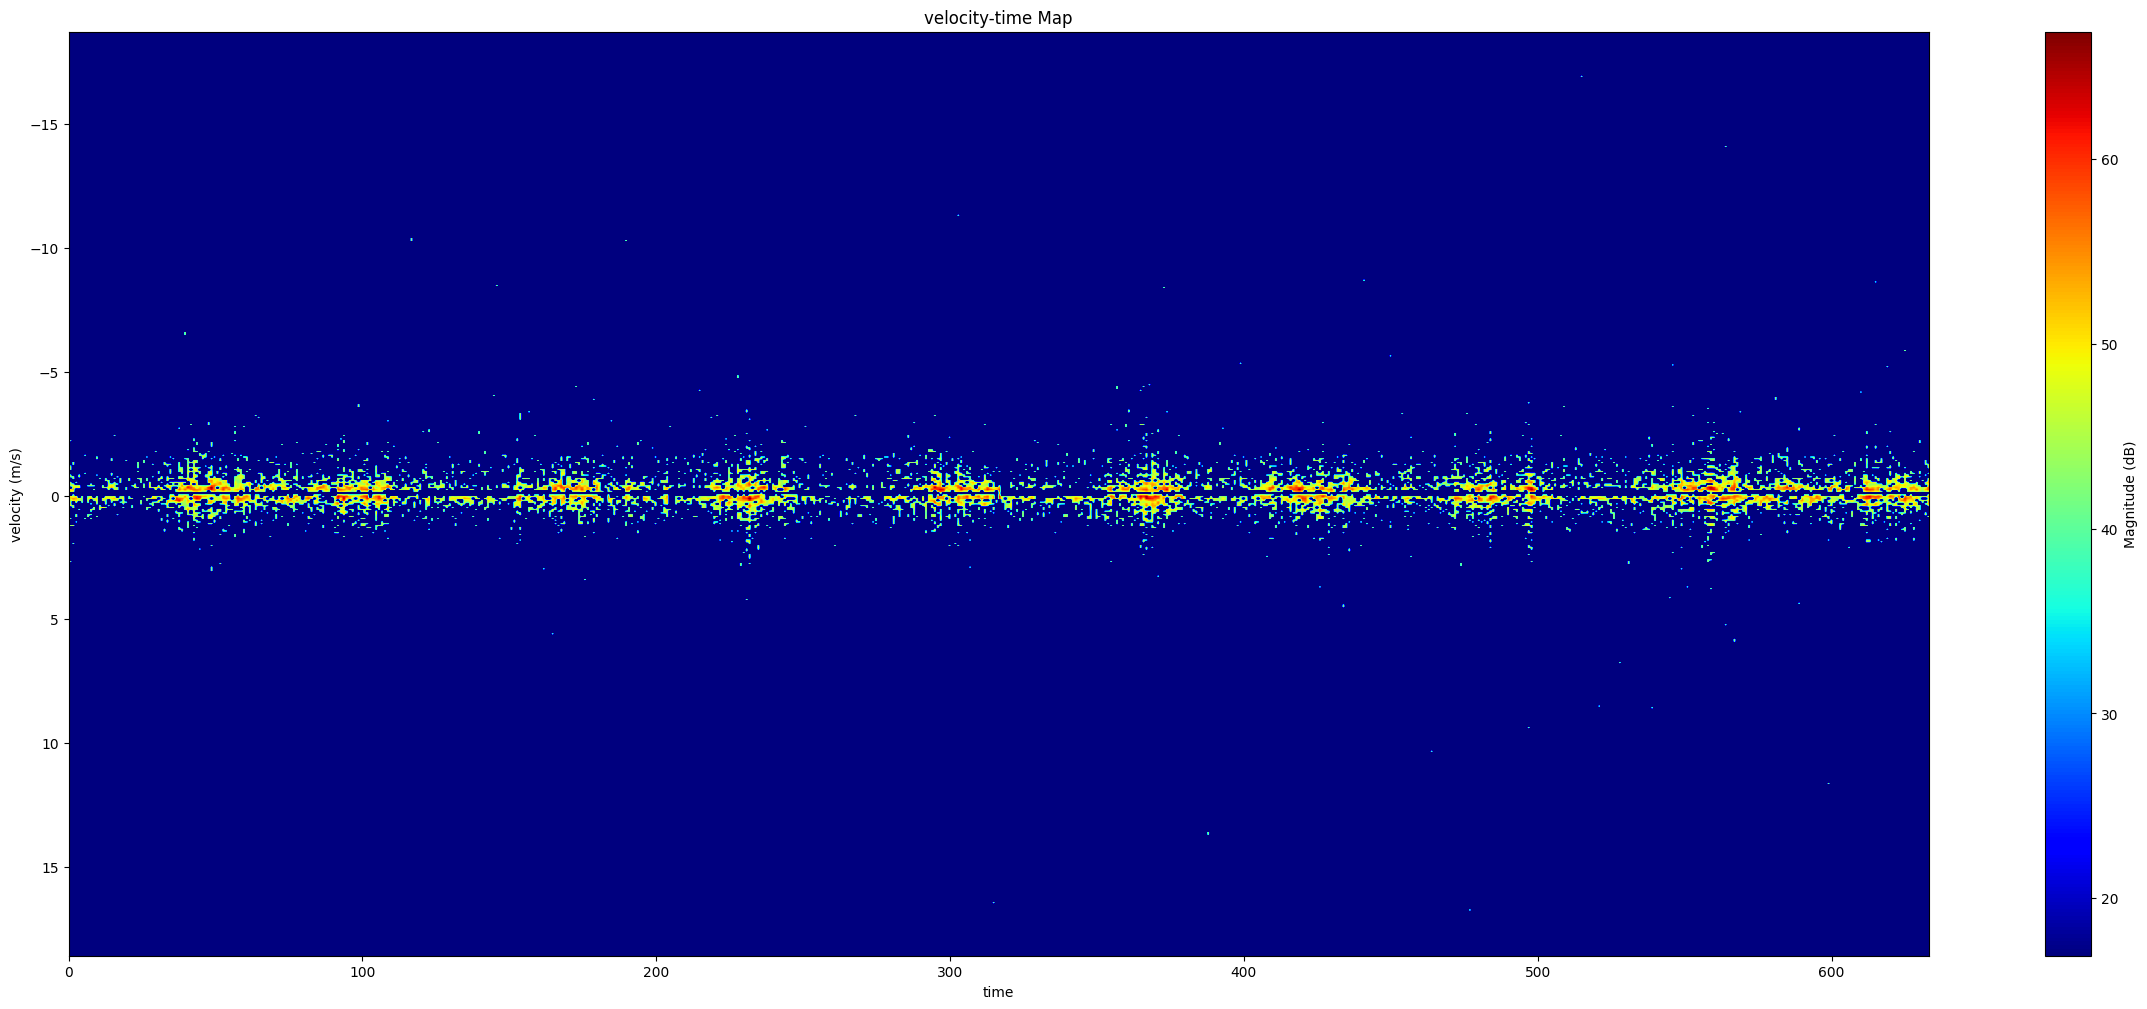

In [33]:
# velocity - time
md_magnitude = np.abs(mD1)
md_magnitude = np.fft.fftshift(md_magnitude, axes=1)
mean = np.mean(md_magnitude)*2.75
# Tìm giá trị nhỏ nhất trong md_magnitude
min_value = np.min(md_magnitude)

# Gán giá trị nhỏ nhất cho các phần tử nhỏ hơn mean
md_magnitude[md_magnitude < mean] = min_value

velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
velocity_bins = np.fft.fftshift(velocity_bins)
plt.figure(figsize=(30, 12))
im =plt.imshow(20 * np.log10(md_magnitude), aspect='auto', cmap='jet', extent=[0, np.size(md_magnitude, 1), velocity_bins.max(), velocity_bins.min()])
# Set the colorbar limits
clim = im.get_clim()
im.set_clim(clim[1] - 50, clim[1])
plt.title('velocity-time Map')
plt.ylabel('velocity (m/s)')
plt.xlabel('time')
plt.colorbar(label='Magnitude (dB)')
plt.show()

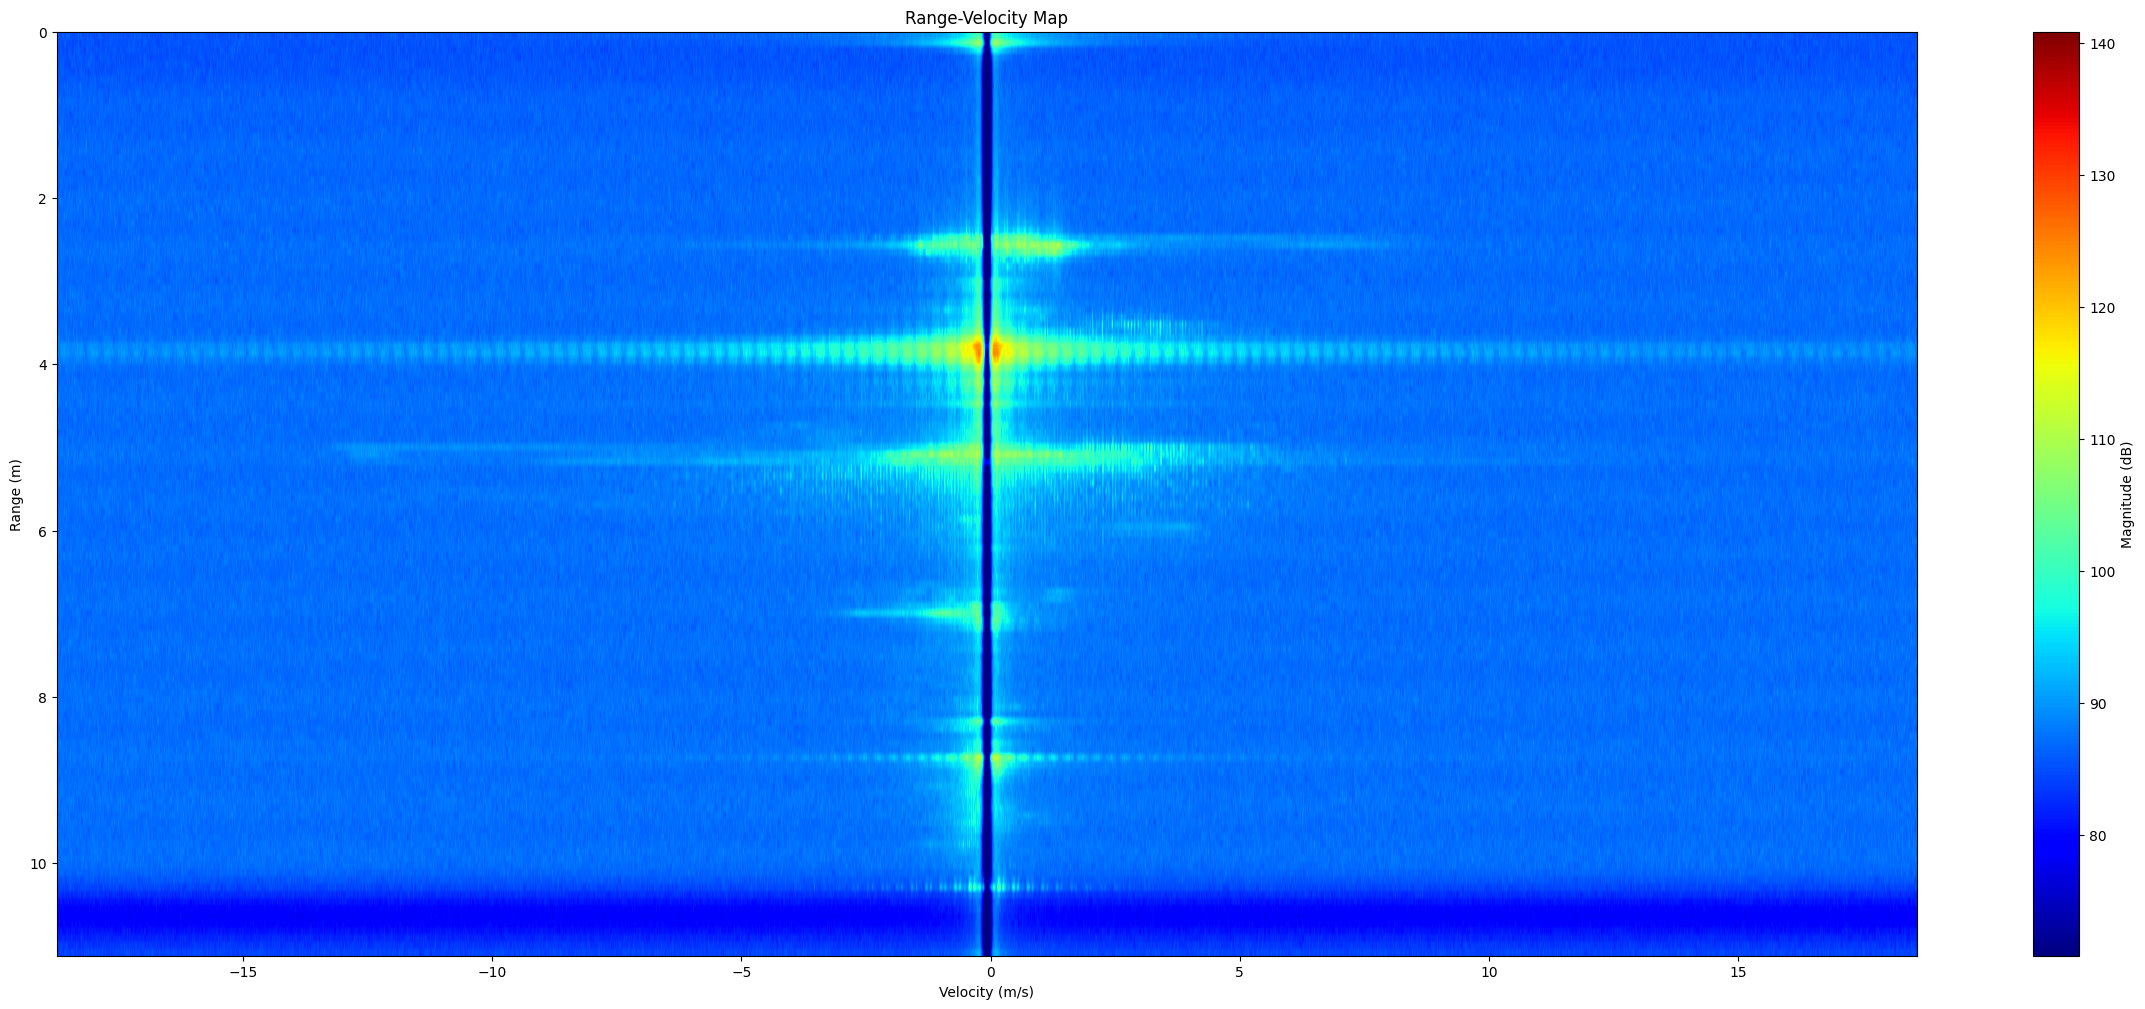

In [34]:
# velocity - range
# Compute the magnitude of the Doppler FFT
doppler_magnitude = np.abs(Dop)
velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
# Shift zero-frequency component to center of spectrum
doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
velocity_bins = np.fft.fftshift(velocity_bins)
# print(velocity_bins.min())
# print(velocity_bins.max())
# Plot the Range-Velocity Map
plt.figure(figsize=(30, 12))
im =plt.imshow(20 * np.log10(doppler_magnitude), aspect='auto', cmap='jet', extent=[velocity_bins.min(), velocity_bins.max(), R_max, 0])
# Set the colorbar limits
clim = im.get_clim()
im.set_clim(clim[1] - 70, clim[1])
plt.title('Range-Velocity Map')
plt.ylabel('Range (m)')
plt.xlabel('Velocity (m/s)')
plt.colorbar(label='Magnitude (dB)')
plt.show()

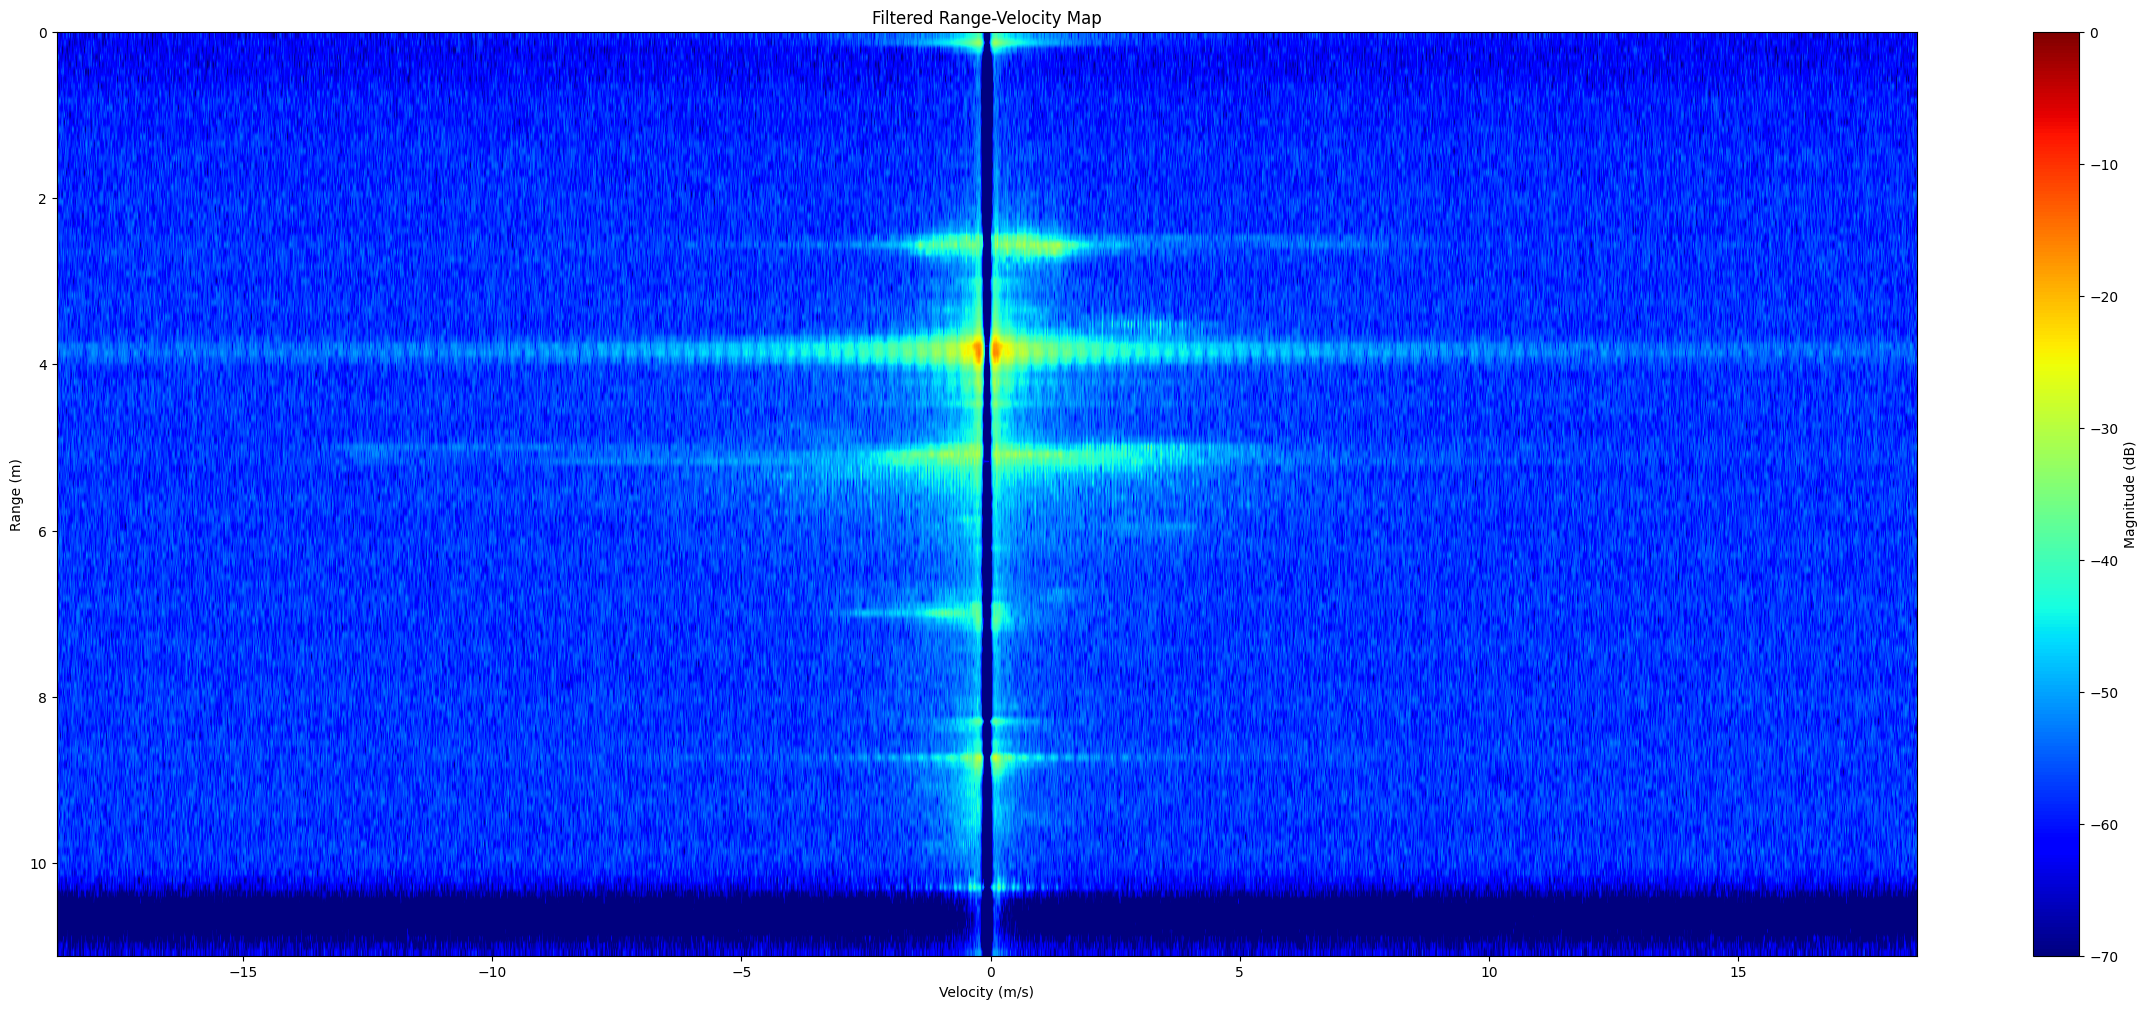

In [35]:
# Doppler FFT and velocity bins (existing code)
doppler_magnitude = np.abs(Dop)
velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
velocity_bins = np.fft.fftshift(velocity_bins)

# Apply MinMax 
doppler_min = doppler_magnitude.min()
doppler_max = doppler_magnitude.max()
doppler_magnitude_normalized = (doppler_magnitude - doppler_min) / (doppler_max - doppler_min)

# Apply filter cho điểm nhỏ hơn threshold
threshold = 0.005
doppler_magnitude_filtered = np.where(doppler_magnitude_normalized > threshold, doppler_magnitude_normalized, 0)

# Tránh trường hợp log(0)
doppler_magnitude_filtered += 1e-10

# Plot the filtered Range-Velocity Map
plt.figure(figsize=(30, 12))
im = plt.imshow(20 * np.log10(doppler_magnitude_filtered), aspect='auto', cmap='jet', extent=[velocity_bins.min(), velocity_bins.max(), R_max, 0])

# Set colorbar limits (if needed)
clim = im.get_clim()
im.set_clim(clim[1] - 70, clim[1])

plt.title('Filtered Range-Velocity Map')
plt.ylabel('Range (m)')
plt.xlabel('Velocity (m/s)')
plt.colorbar(label='Magnitude (dB)')
plt.show()


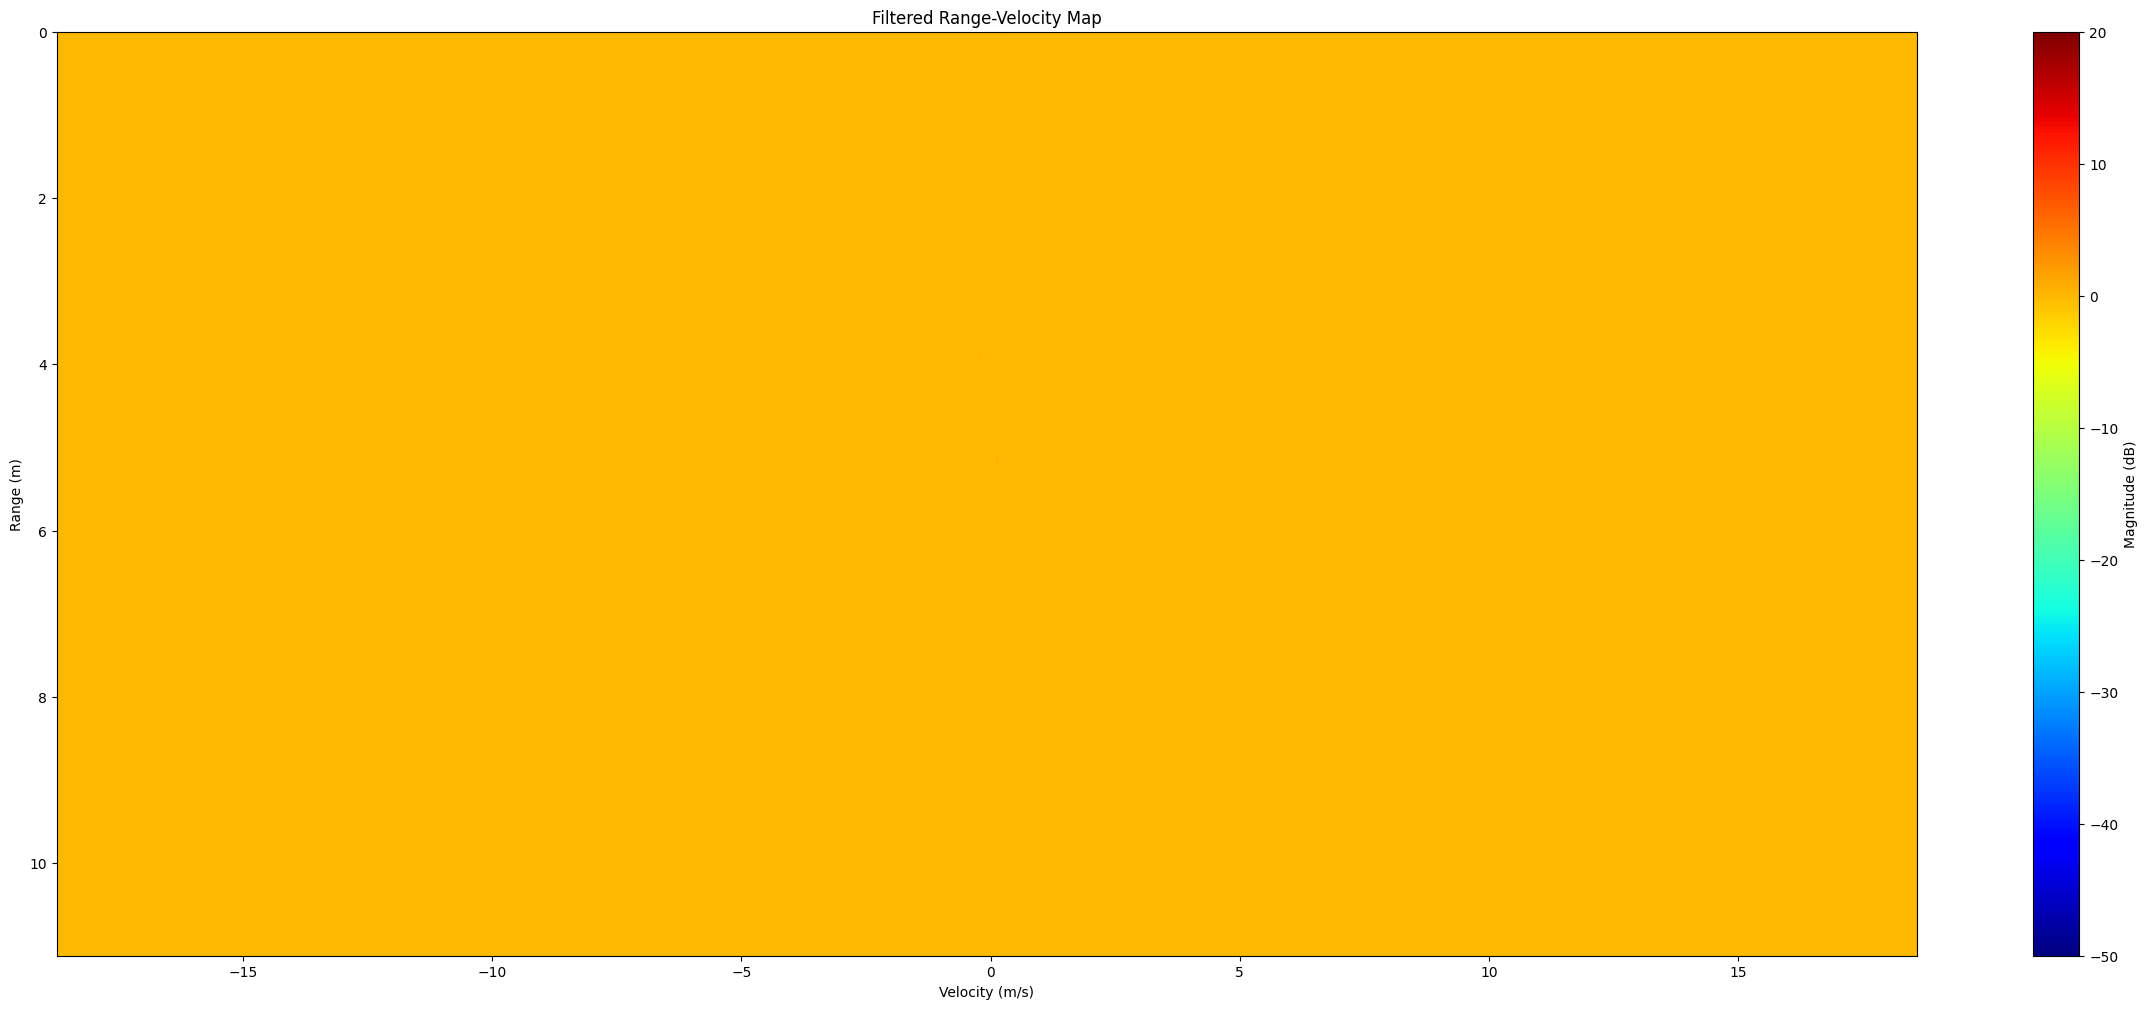

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Doppler FFT and velocity bins (existing code)
doppler_magnitude = np.abs(Dop)
velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
velocity_bins = np.fft.fftshift(velocity_bins)

# Apply MinMax normalization
doppler_min = doppler_magnitude.min()
doppler_max = doppler_magnitude.max()
doppler_magnitude_normalized = (doppler_magnitude - doppler_min) / (doppler_max - doppler_min)

# Apply filter to each point on the map
threshold = 0.5
doppler_magnitude_filtered = np.where(doppler_magnitude_normalized > threshold, doppler_magnitude_normalized, 0)

# Avoid log(0) by adding a small epsilon value
doppler_magnitude_filtered += 1e-10

# Plot the filtered Range-Velocity Map
plt.figure(figsize=(30, 12))
im = plt.imshow(20 * (doppler_magnitude_filtered), aspect='auto', cmap='jet', extent=[velocity_bins.min(), velocity_bins.max(), R_max, 0])

# Set colorbar limits (if needed)
clim = im.get_clim()
im.set_clim(clim[1] - 70, clim[1])

plt.title('Filtered Range-Velocity Map')
plt.ylabel('Range (m)')
plt.xlabel('Velocity (m/s)')
plt.colorbar(label='Magnitude (dB)')
plt.show()

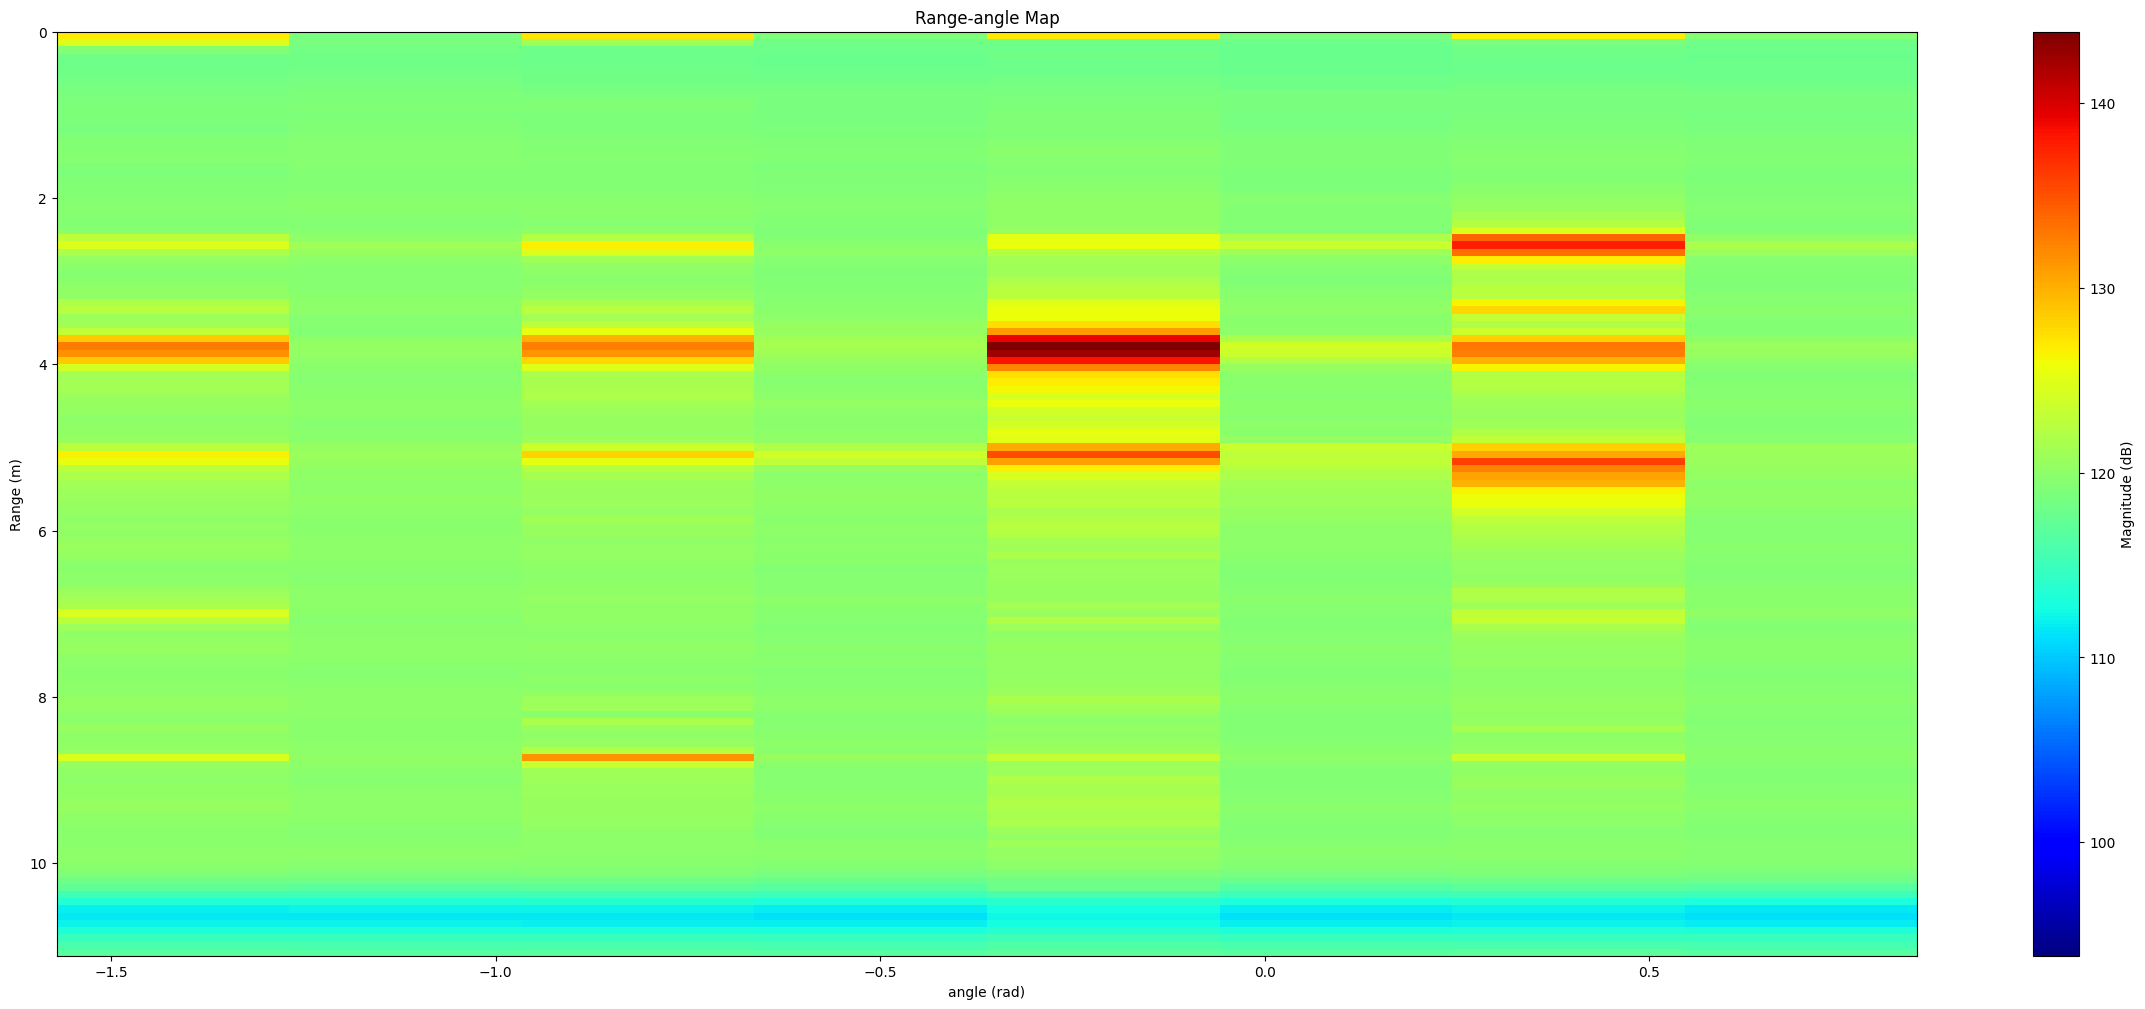

In [37]:
# range-azimuth
# print(np.size(rD_all, 2))
# print(np.shape(rD_all))
# num_horizon = np.size(rD1, 1)//3
horizon = []
for i in range(0, np.size(rD1, 1), 3):
    if i+2 < np.size(rD1, 1):
        stacked = np.vstack((rD1[:, i], rD2[:, i], rD3[:, i], rD4[:, i], rD1[:, i+2], rD2[:, i+2], rD3[:, i+2], rD4[:, i+2])).T
        horizon.append(stacked)


# horizon gồm nhiều mảng xếp chồng lên nhau, mỗi mảng có kích thước samp/chirp * 8 (virture antena theo phương ngang)
horizon = np.array(horizon)
# print(np.shape(horizon))
# print(np.shape(horizon[1]))
test = np.fft.fft(horizon, axis=2)
test_magnitude = np.zeros((np.size(horizon, 1), np.size(horizon, 2)))
t = np.size(test, 0)//23
for i in range(9*t, 11*t):
    test_magnitude = test_magnitude+ abs(test[i])
    # test_magnitude = test_magnitude
omega_res = (2*np.pi)/8
omega_bins = np.fft.fftfreq(8, d=1/8) * omega_res
normalized_bins = np.clip(omega_bins / np.pi, -1, 1)
theta_bin = np.arcsin(normalized_bins)
test_magnitude = np.fft.fftshift(test_magnitude, axes=1)
theta_bin = np.fft.fftshift(theta_bin)
# print(theta_bin)
plt.figure(figsize=(30, 12))
im =plt.imshow(20 * np.log10(test_magnitude), aspect='auto', cmap='jet', extent=[theta_bin.min(), theta_bin.max(), R_max, 0])
# Set the colorbar limits
clim = im.get_clim()
im.set_clim(clim[1] - 50, clim[1])
plt.title('Range-angle Map')
plt.ylabel('Range (m)')
plt.xlabel('angle (rad)')
plt.colorbar(label='Magnitude (dB)')
plt.show()



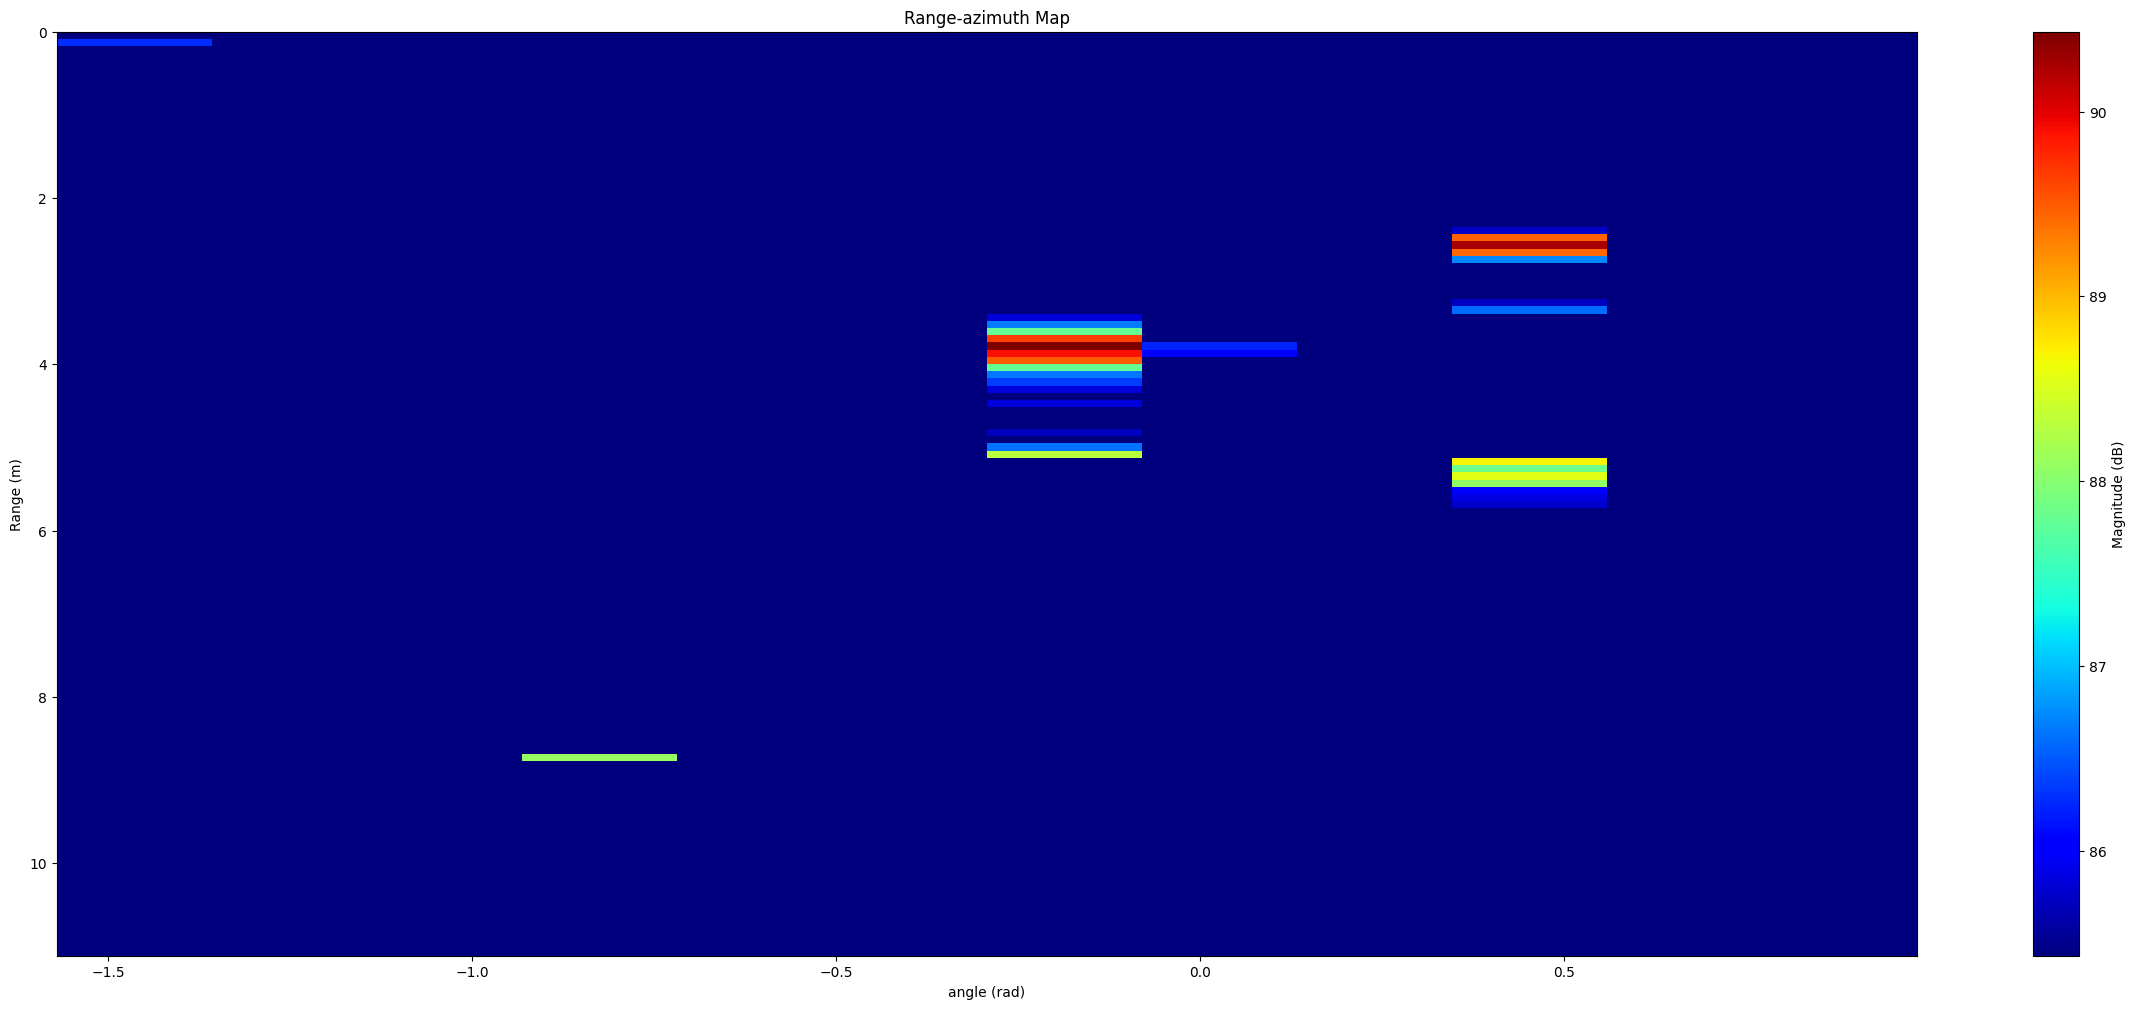

In [38]:
# rang_azimuth (tăng cường độ phân giải)
horizon = []
for i in range(0, np.size(rD1, 1), 3):
    if i+2 < np.size(rD1, 1):
        alpha = (np.angle(rD1[:,i+1])+np.angle(rD2[:,i+1])+np.angle(rD3[:,i+1])+np.angle(rD4[:,i+1])-np.angle(rD1[:,i])-np.angle(rD2[:,i])-np.angle(rD3[:,i])-np.angle(rD4[:,i]))/4
        alpha = np.exp(-1j*alpha).T
        stacked = np.vstack((rD1[:, i], rD2[:, i], rD3[:, i], rD4[:, i], rD1[:, i+2], rD2[:, i+2], rD3[:, i+2], rD4[:, i+2], rD1[:, i+1], rD2[:, i+1], rD3[:, i+1], rD4[:, i+1])).T
        stacked = stacked/np.abs(stacked)
        
        stacked[:, 8] = stacked[:, 8] * alpha * stacked[:, 1] * stacked[:, 7]
        stacked[:, 9] = stacked[:, 9] * alpha * stacked[:, 2] * stacked[:, 6]
        stacked[:, 10]= stacked[:, 10] * alpha * stacked[:, 3] * stacked[:, 5]
        stacked[:, 11]= stacked[:, 11] * alpha * stacked[:, 4] * stacked[:, 4]

        horizon.append(stacked)

horizon = np.array(horizon)
# print(np.shape(horizon))
# print(np.shape(horizon[1]))
test = np.fft.fft(horizon, axis=2)
test_magnitude = np.zeros((np.size(horizon, 1), np.size(horizon, 2)))
t = np.size(test, 0)//23
for i in range(9*t, 11*t):
    test_magnitude = test_magnitude+ abs(test[i])
    # test_magnitude = test_magnitude

omega_res = (2*np.pi)/12
omega_bins = np.fft.fftfreq(12, d=1/12) * omega_res
normalized_bins = np.clip(omega_bins / np.pi, -1, 1)
theta_bin = np.arcsin(normalized_bins)
test_magnitude = np.fft.fftshift(test_magnitude, axes=1)
theta_bin = np.fft.fftshift(theta_bin)
# print(theta_bin)
plt.figure(figsize=(30, 12))
im =plt.imshow(20 * np.log10(test_magnitude), aspect='auto', cmap='jet', extent=[theta_bin.min(), theta_bin.max(), R_max, 0])
# Set the colorbar limits
clim = im.get_clim()
im.set_clim(clim[1] - 5, clim[1])
plt.title('Range-azimuth Map')
plt.ylabel('Range (m)')
plt.xlabel('angle (rad)')
plt.colorbar(label='Magnitude (dB)')
plt.show()

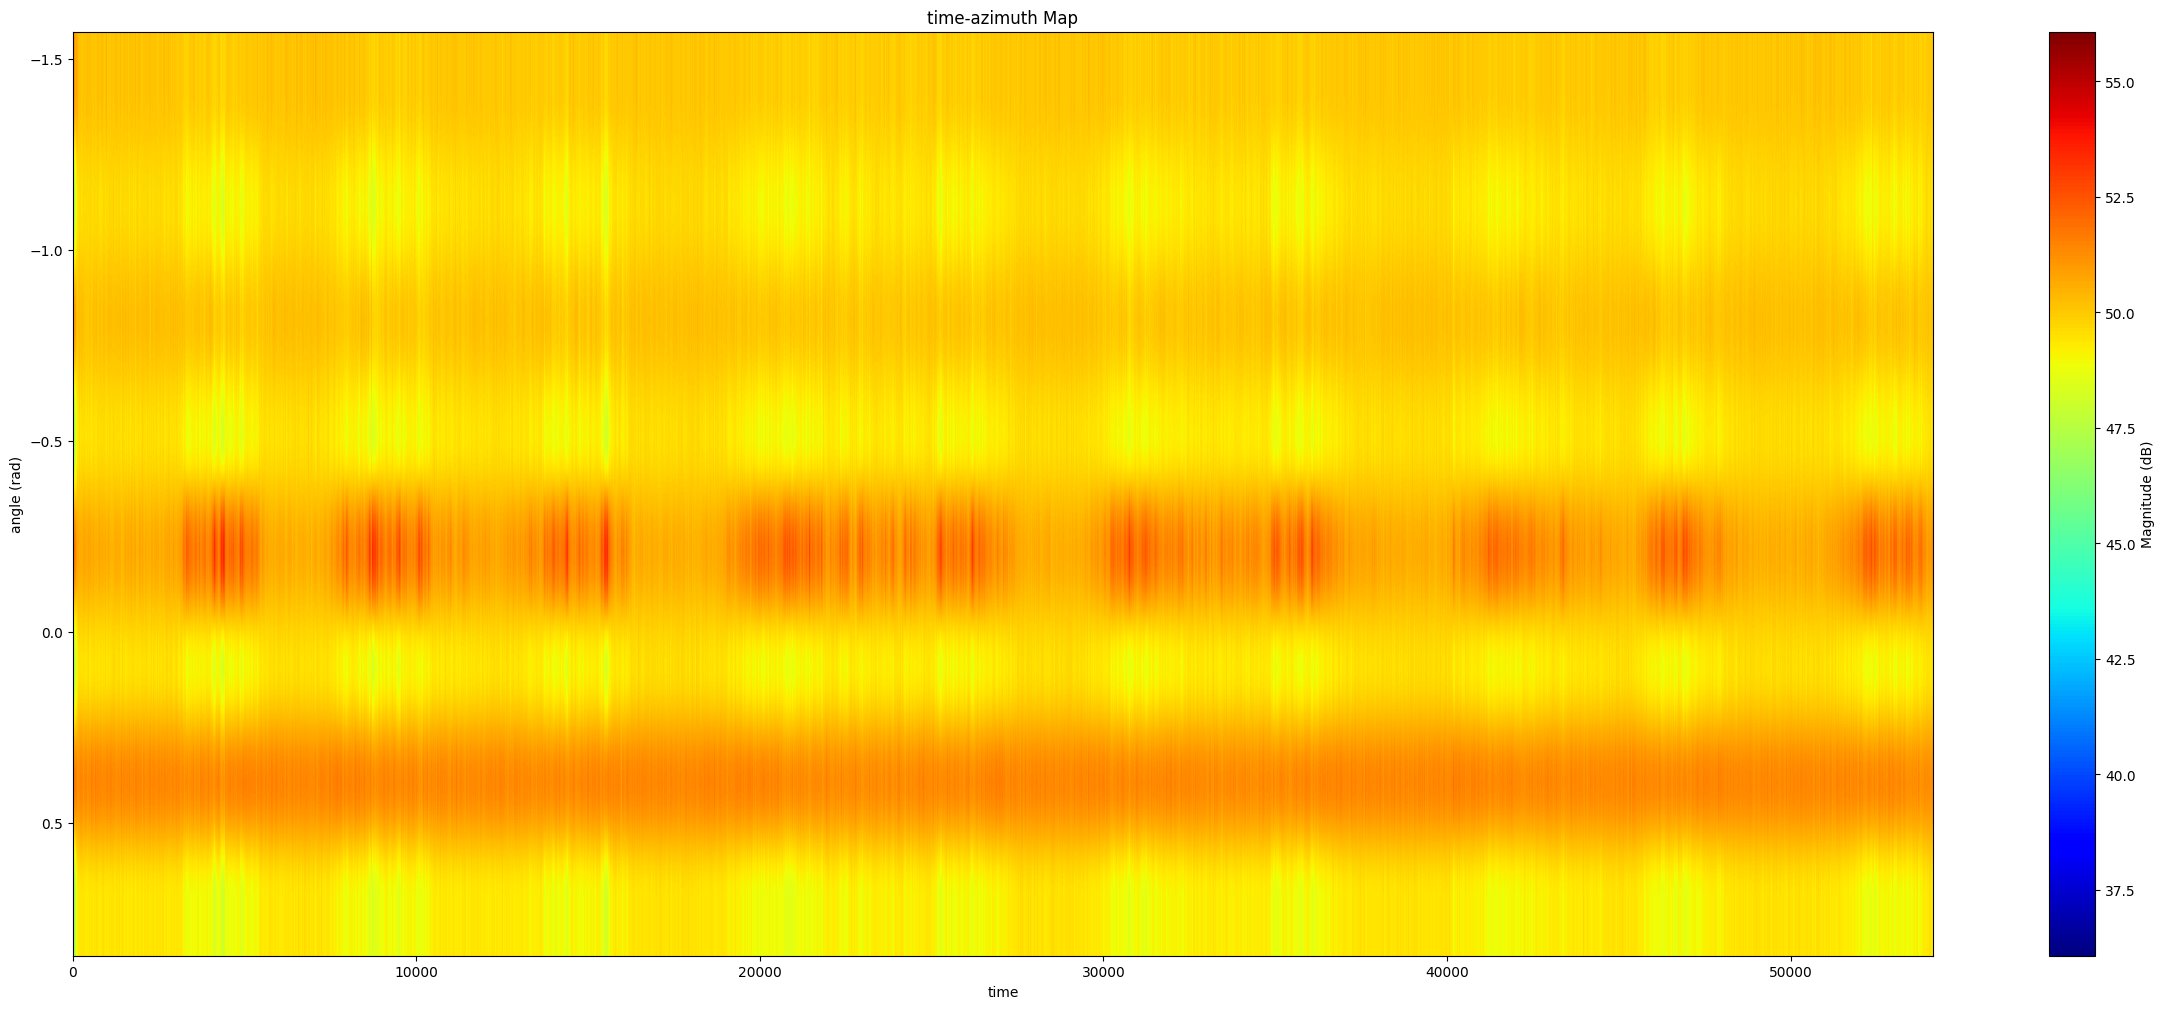

In [39]:
# azimuth-time
num_horizon = np.size(rD1, 1)//3
horizon = []
for i in range(0, np.size(rD1, 1), 3):
    if i+2 < np.size(rD1, 1):
        stacked = np.vstack((rD1[:, i], rD2[:, i], rD3[:, i], rD4[:, i], rD1[:, i+2], rD2[:, i+2], rD3[:, i+2], rD4[:, i+2])).T
        stacked = stacked/np.abs(stacked)
        horizon.append(stacked)

# horizon gồm nhiều mảng xếp chồng lên nhau, mỗi mảng có kích thước samp/chirp * 8 (virture antena theo phương ngang)
horizon = np.array(horizon)
# print(np.shape(horizon))
# print(np.shape(horizon[1]))
test = np.fft.fft(horizon, axis=2)
test_magnitude = []
for i in range(np.size(test, 0)):
    sum_array = np.sum(abs(test[i]), axis=0)
    test_magnitude.append(sum_array)


omega_res = (2*np.pi)/8
omega_bins = np.fft.fftfreq(8, d=1/8) * omega_res
normalized_bins = np.clip(omega_bins / np.pi, -1, 1)
theta_bin = np.arcsin(normalized_bins)
test_magnitude = np.fft.fftshift(test_magnitude, axes=1)
theta_bin = np.fft.fftshift(theta_bin)
plt.figure(figsize=(30, 12))
im =plt.imshow(20 * np.log10(test_magnitude.T), aspect='auto', cmap='jet', extent=[0, np.size(test_magnitude,0), theta_bin.max(), theta_bin.min()])
# Set the colorbar limits
clim = im.get_clim()
im.set_clim(clim[1] - 20, clim[1])
plt.title('time-azimuth Map')
plt.xlabel('time')
plt.ylabel('angle (rad)')
plt.colorbar(label='Magnitude (dB)')
plt.show()

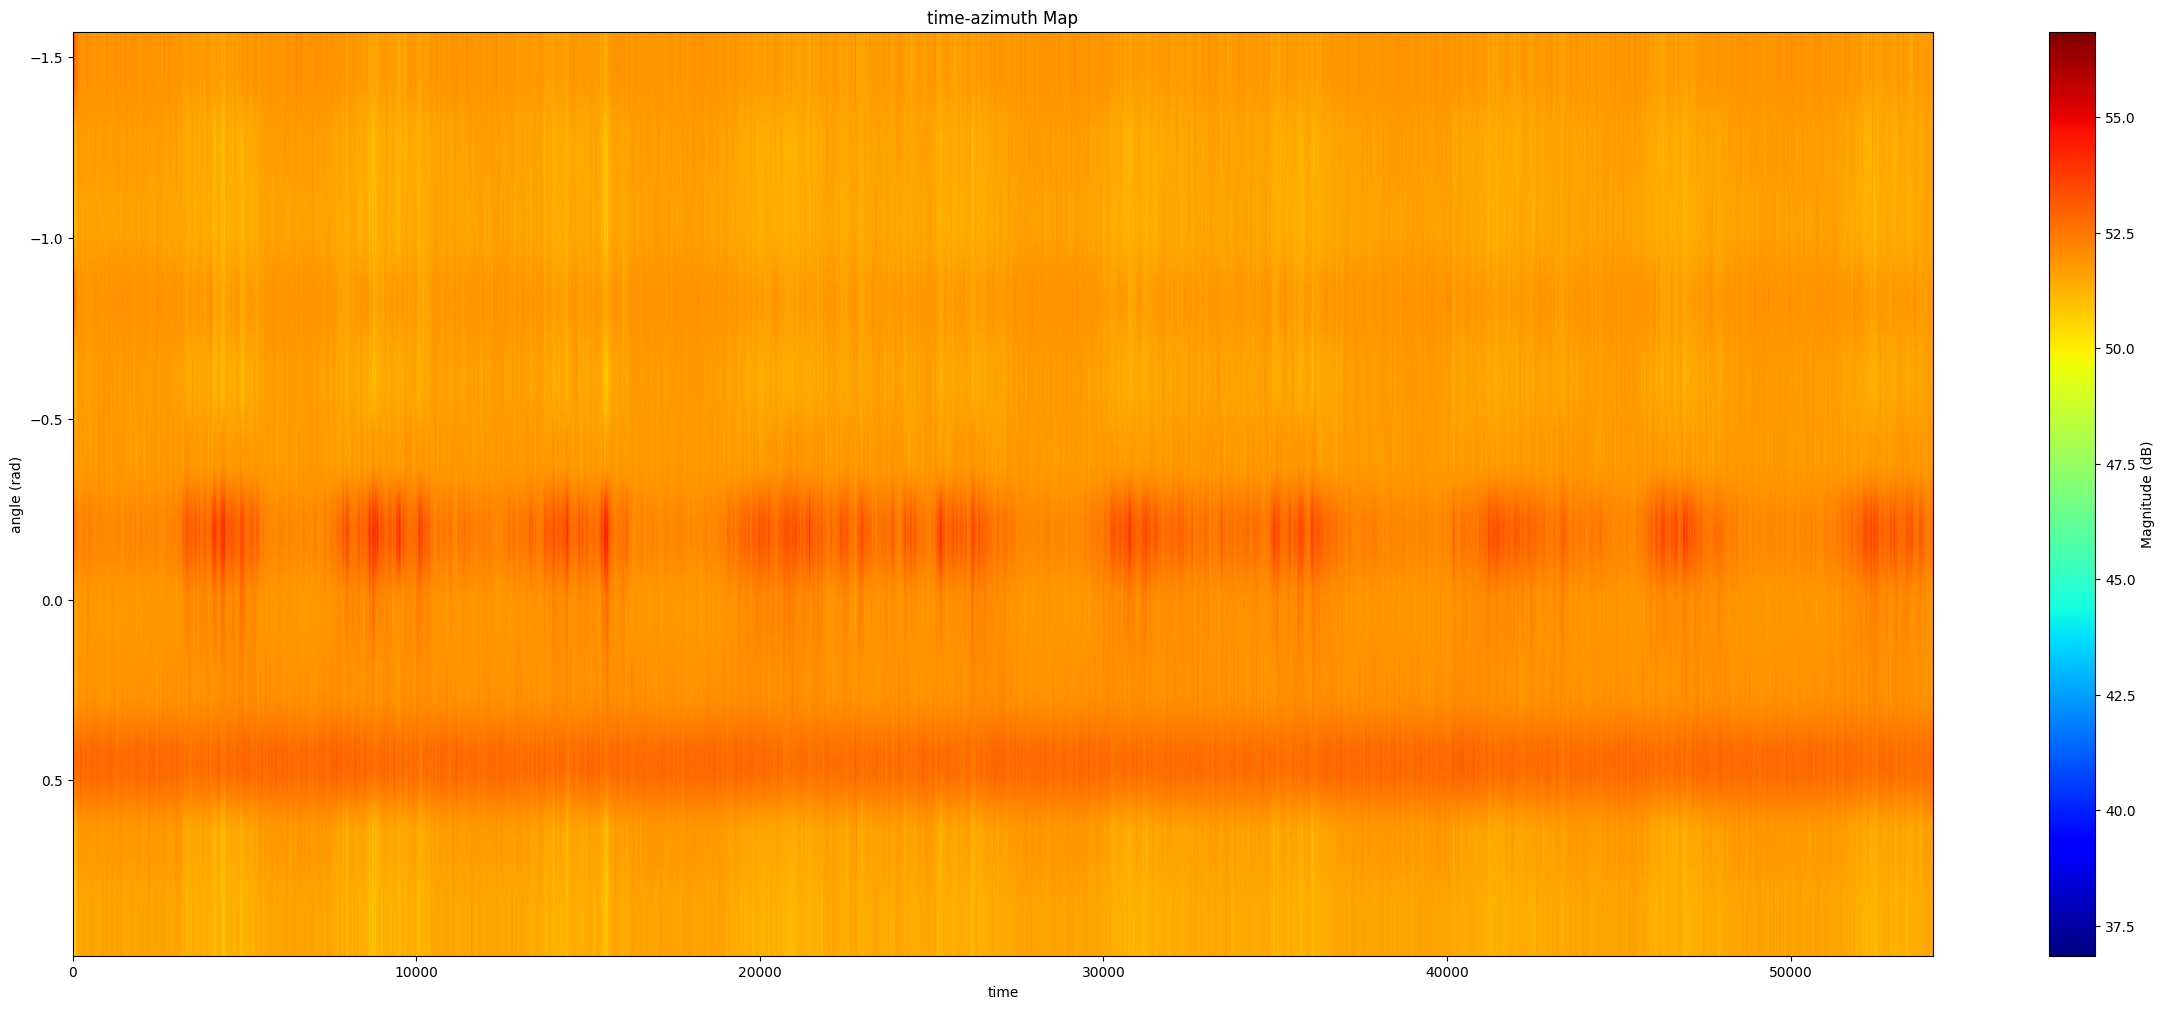

In [40]:
# azimuth-time tăng cường độ phân giải
num_horizon = np.size(rD1, 1)//3
horizon = []
for i in range(0, np.size(rD1, 1), 3):
    if i+2 < np.size(rD1, 1):
        # tim goc lech alpha giua Tx2 va Tx1
        alpha = (np.angle(rD1[:,i+1])+np.angle(rD2[:,i+1])+np.angle(rD3[:,i+1])+np.angle(rD4[:,i+1])-np.angle(rD1[:,i])-np.angle(rD2[:,i])-np.angle(rD3[:,i])-np.angle(rD4[:,i]))/4
        alpha = np.exp(-1j*alpha).T
        stacked = np.vstack((rD1[:, i], rD2[:, i], rD3[:, i], rD4[:, i], rD1[:, i+2], rD2[:, i+2], rD3[:, i+2], rD4[:, i+2], rD1[:, i+1], rD2[:, i+1], rD3[:, i+1], rD4[:, i+1])).T
        stacked = stacked/np.abs(stacked)
        
        stacked[:, 8] = stacked[:, 8] * alpha *stacked[:, 1]*stacked[:, 7]
        stacked[:, 9] = stacked[:, 9] * alpha*stacked[:, 2]*stacked[:, 6]
        stacked[:, 10]= stacked[:, 10] *alpha* stacked[:, 3] *stacked[:, 5]
        stacked[:, 11]= stacked[:, 11]*alpha*stacked[:, 4]*stacked[:, 4]

        horizon.append(stacked)
# print(np.shape(horizon))
horizon = np.array(horizon)
# print(np.shape(horizon))
# print(np.shape(horizon[1]))
test = np.fft.fft(horizon, axis=2)
test_magnitude = []
for i in range(np.size(test, 0)):
    sum_array = np.sum(abs(test[i]), axis=0)
    test_magnitude.append(sum_array)


omega_res = (2*np.pi)/12
omega_bins = np.fft.fftfreq(12, d=1/12) * omega_res
normalized_bins = np.clip(omega_bins / np.pi, -1, 1)
theta_bin = np.arcsin(normalized_bins)
test_magnitude = np.fft.fftshift(test_magnitude, axes=1)
theta_bin = np.fft.fftshift(theta_bin)
plt.figure(figsize=(30, 12))
im =plt.imshow(20 * np.log10(test_magnitude.T), aspect='auto', cmap='jet', extent=[0, np.size(test_magnitude,0), theta_bin.max(), theta_bin.min()])
# Set the colorbar limits
clim = im.get_clim()
im.set_clim(clim[1] - 20, clim[1])
plt.title('time-azimuth Map')
plt.xlabel('time')
plt.ylabel('angle (rad)')
plt.colorbar(label='Magnitude (dB)')
plt.show()

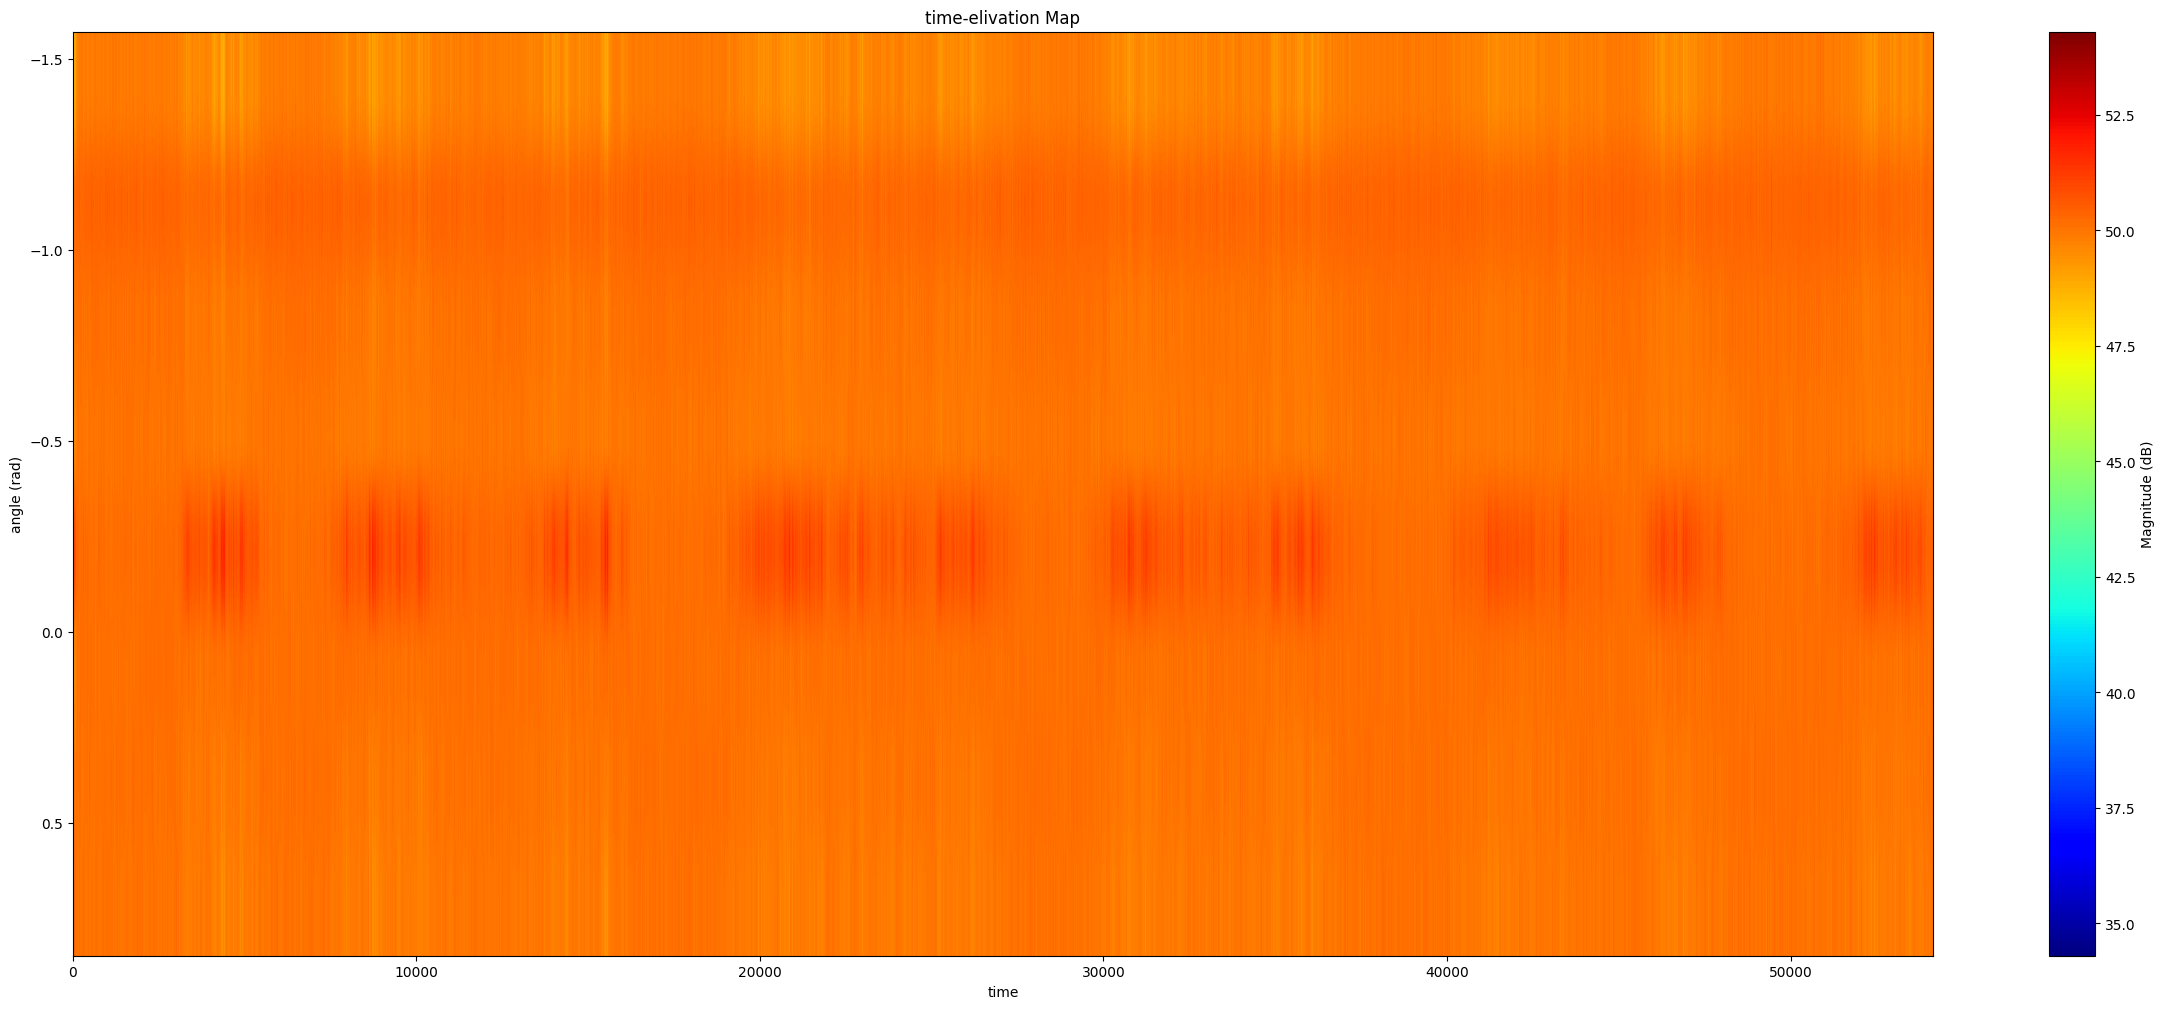

In [41]:
# elivation angle - time
elivation = []
for i in range(0, np.size(rD1, 1), 3):
    if i+2 < np.size(rD1, 1):
        # tim goc lech theta
        theta = (-np.angle(rD1[:,i+1])*2-np.angle(rD2[:,i+1])*2-np.angle(rD3[:,i+1])*2-np.angle(rD4[:,i+1])*2+np.angle(rD2[:,i])+np.angle(rD3[:,i])*2+np.angle(rD4[:,i])*2+np.angle(rD1[:,i+2])*2+np.angle(rD2[:, i+2]))/4
        theta = np.exp(1j*theta).T
        stacked = np.vstack((rD1[:, i+1], rD3[:, i], rD2[:, i+1], rD4[:, i], rD3[:, i+1], rD1[:, i+2], rD4[:, i+1], rD2[:, i+2])).T
        stacked = stacked/np.abs(stacked)
        
        stacked[:, 2] = stacked[:, 2] * theta
        stacked[:, 3] = stacked[:, 3] * theta
        stacked[:, 4]= stacked[:, 4] *(theta**2)
        stacked[:, 5]= stacked[:, 5]*(theta**2)
        stacked[:, 6]= stacked[:, 6]*(theta**3)
        stacked[:, 7]= stacked[:, 7]*(theta**3)

        elivation.append(stacked)

elivation = np.array(elivation)
test = np.fft.fft(elivation, axis=2)
test_magnitude = []
for i in range(np.size(test, 0)):
    sum_array = np.sum(abs(test[i]), axis=0)
    test_magnitude.append(sum_array)


omega_res = (2*np.pi)/8
omega_bins = np.fft.fftfreq(8, d=1/8) * omega_res
normalized_bins = np.clip(omega_bins / np.pi, -1, 1)
theta_bin = np.arcsin(normalized_bins)
test_magnitude = np.fft.fftshift(test_magnitude, axes=1)
theta_bin = np.fft.fftshift(theta_bin)
plt.figure(figsize=(30, 12))
im =plt.imshow(20 * np.log10(test_magnitude.T), aspect='auto', cmap='jet', extent=[0, np.size(test_magnitude,0), theta_bin.max(), theta_bin.min()])
# Set the colorbar limits
clim = im.get_clim()
im.set_clim(clim[1] - 20, clim[1])
plt.title('time-elivation Map')
plt.xlabel('time')
plt.ylabel('angle (rad)')
plt.colorbar(label='Magnitude (dB)')
plt.show()